In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import importlib 

import colors, plot_func

In [34]:
# k_stiff = np.array([1, 1])
# k_soft = np.array([1, 0.0001])
# thresh = np.array([40, 20])
# theta_ss = np.array([20, 20])
# init_buckle = np.array([1, 1])
# desired_buckle = np.array([-1, 1])

k_stiff = np.array([4.2, 2.0, 1.0, 1.0])
k_soft = np.array([0.2, 0.5, 0.1, 0.4])
thresh = np.array([30, 25, 15, 10])
theta_ss = np.array([25, 15, 10, 5])
init_buckle = np.array([-1, 1, -1, -1])
desired_buckle = np.array([1, -1, -1, 1])

# k_stiff = np.array([4.2, 2.0, 1.0])
# k_soft = np.array([0.2, 0.5, 0.1])
# thresh = np.array([30, 25, 15])
# theta_ss = np.array([5, 15, 10])
# init_buckle = np.array([-1, 1, 1])
# desired_buckle = np.array([1, 1, -1])

# k_stiff = np.array([1.0, 1.0])
# k_soft = np.array([1.0, 1.0])
# thresh = np.array([40, 20])
# theta_ss = np.array([0, 0])
# init_buckle = np.array([1, 1])
# desired_buckle = np.array([-1, -1])

supress_prints = False

problem = 'tau'

In [35]:
iterations = 50
alpha = 0.025

In [36]:
## Classes

class VariablesClass:
    """
    Class with variables dictated by supervisor
    """
    def __init__(self, k_stiff, k_soft, thresh, theta_ss):
        self.k_stiff = k_stiff
        self.k_soft = k_soft
        self.thresh = thresh
        self.theta_ss = theta_ss
        self.N_springs = np.size(k_stiff)
        
        # correct for un-physical threshold to move shim
        self.thresh[self.thresh<self.theta_ss] = self.theta_ss[self.thresh<self.theta_ss]
        
        # soft always 
        self.k_soft[self.k_soft>self.k_stiff] = self.k_stiff[self.k_soft>self.k_stiff]
    
    def set_normalizations(self, k_stiff, k_soft, theta_ss):
        self.k_bar = np.mean([np.mean(k_stiff), np.mean(k_soft)])
        self.theta_bar = np.mean(theta_ss)

        
class SupervisorClass:
    """
    Class with variables dictated by supervisor
    """
    def __init__(self, desired_buckle, alpha):
        self.desired_buckle = desired_buckle
        self.input_in_t = []
        self.input_update_in_t = []
        self.loss_in_t = []
        self.loss_MSE_in_t = []
        self.alpha = alpha
        
        self.input_update = 0
        self.input_update_in_t.append(self.input_update)
        
    def init_dataset(self, iterations, problem):
        self.iterations = iterations
        # self.theta_vec = np.array([-50, -40, -30, -20, -10, 0, 10, 20, 30, 40, 50])
        if problem == 'tau':
            self.theta_vec = np.random.uniform(-90, 90, iterations)
        elif problem == 'Fy':
            self.theta_1_vec = np.random.uniform(-90, 90, iterations)
            self.theta_2_vec = np.random.uniform(-90, 90, iterations)
            self.x_vec, self.y_vec = forward_points(L, self.theta_1_vec, self.theta_2_vec)
    
    def desired_tau(self):
        self.desired_tau_vec = np.zeros(np.size(self.theta_vec))
        for i, theta in enumerate(self.theta_vec):
            self.desired_tau_vec[i] = tau_hinge(theta, self.desired_buckle, Variabs)
            
    def set_theta(self, iteration):
        self.theta = self.theta_vec[iteration]
        self.desired_tau = self.desired_tau_vec[i]
        print('theta ', self.theta)
        
    def set_pos(self, iteration):
        self.x, self.y = self.x_vec[iteration], self.y_vec[iteration]
        self.desired_Fy = self.desired_Fy_vec[i]
        
    def calc_loss(self, tau):
        self.loss = loss(self.desired_tau, tau)
        self.loss_MSE = loss_MSE(self.loss)
        self.loss_in_t.append(self.loss)
        self.loss_MSE_in_t.append(self.loss_MSE)
        if not supress_prints:
            print('desired tau ', self.desired_tau)
            print('loss ', self.loss)
            print('MSE loss ', self.loss_MSE)
        
    def calc_input_update(self, State, Supervisor, Variabs):
        delta_theta = input_update(State.tau, Supervisor.loss, Supervisor.theta, Variabs.k_bar, Variabs.theta_bar)
        input_update_nxt = copy.copy(self.input_update) + self.alpha * delta_theta
        self.input_update = input_update_nxt
        self.input_update_in_t.append(self.input_update)
        if not supress_prints:
            print('delta theta', delta_theta)
            print('input_update ', self.input_update)


class StateClass:
    """
    Class with state variables
    """
    def __init__(self, Variabs, Supervisor, buckle=None):
        # self.buckle_in_t = np.zeros([Supervisor.iterations, Variabs.N_springs])
        # self.tau_in_t = np.zeros(Supervisor.iterations)
        self.buckle_in_t = []
        self.tau_in_t = []
        
        if buckle is not None:
            self.buckle = buckle
        else:
            self.buckle = np.ones(Variabs.N_springs)
        if not supress_prints:
            print('buckle pattern ', self.buckle)
        self.buckle_in_t.append(self.buckle)

    def calc_tau(self, theta, Variabs):
        self.tau = tau_hinge(theta, self.buckle, Variabs) 
        if not supress_prints:
            print('tau ', self.tau)
            
    def evolve_material(self, Supervisor, Variabs):
        buckle_nxt = np.zeros(Variabs.N_springs)
        for i in range(Variabs.N_springs):
            if self.buckle[i] == 1 and Supervisor.input_update > Variabs.thresh[i]:  # buckle left
                buckle_nxt[i] = -1
            elif self.buckle[i] == -1 and Supervisor.input_update < -Variabs.thresh[i]:  # buckle right
                buckle_nxt[i] = 1
            else:
                buckle_nxt[i] = self.buckle[i]
        self.buckle = copy.copy(buckle_nxt)
        self.buckle_in_t.append(self.buckle)
        if not supress_prints:
            print('buckle pattern ', self.buckle)       

In [37]:
def tau_tot():
    return (np.sum(tau_hinge(theta, buckle, Variabs)**(-1)))**(-1)


def tau_hinge(theta, buckle, Variabs):
    return np.sum(tau_k(theta, buckle, Variabs))
    

def tau_k(theta, buckle, Variabs):
    tau_k = np.zeros(Variabs.N_springs)
    for i in range(Variabs.N_springs):
        if buckle[i] == 1 and theta > -Variabs.theta_ss[i] or buckle[i] == -1 and theta < Variabs.theta_ss[i]:
            k = Variabs.k_stiff[i]
        else:
            k = Variabs.k_soft[i]
        tau_k[i] = -k * (theta - (-buckle[i]) * Variabs.theta_ss[i])
    return tau_k


def loss(desired_tau, tau):
    return desired_tau - tau


def loss_MSE(loss):
    return np.mean(loss**2)


def input_update(tau, loss, theta, k_bar, theta_bar):
    tau_pre = 1
    theta_pre = -1
    # return (tau/k_bar-theta)*(loss)/(k_bar*theta_bar)
    # return (theta/theta_bar)*(loss)/(k_bar*theta_bar)
    return (tau_pre*tau/k_bar+theta_pre*theta)*(loss)/(k_bar*theta_bar)


def measure_full_response(Variabs, buckle, length=100):
    theta_vec = np.linspace(-180, 180, length)
    tau_vec = np.zeros([length])
    for i, theta in enumerate(theta_vec):
        tau_vec[i] = tau_hinge(theta, buckle, Variabs)
    return theta_vec, tau_vec

In [38]:
def theta_from_xy(x, y, buckle, L=1.0):
    """
    Return (theta1, theta2) where:
      - theta2 is the relative elbow angle (same as before).
      - theta1 is the base angle measured from the VERTICAL (+y axis).
        If ccw_from_vertical=False, it will be clockwise-from-vertical.

    buckle = +1  -> elbow-up branch
    buckle = -1  -> elbow-down branch
    """
    # IK for 2R with L1=L2=L
    c2 = (x**2 + y**2 - 2*L**2) / (2*L**2)
    c2 = np.clip(c2, -1.0, 1.0)

    s2 = np.sqrt(max(0.0, 1.0 - c2**2))
    if buckle == 1:
        theta2 = np.arctan2(+s2, c2)
    else:
        theta2 = np.arctan2(-s2, c2)

    # q1 measured from +x (standard)
    q1_from_x = np.arctan2(y, x) - theta2/2
    theta1    = q1_from_x - np.pi/2

    return theta1, theta2


def Fy(theta1, theta2, tau1, tau2):
    return (np.sin(theta1)*tau2 + np.sin(theta1+theta2)*(tau2-tau1))/np.sin(theta2)


def forward_points(L, theta1, theta2):
    p0 = np.array([0.0, 0.0])
    p1 = p0 + L*np.array([-np.sin(theta1), np.cos(theta1)])
    p2 = p1 + L*np.array([-np.sin(theta1+theta2), np.cos(theta1+theta2)])
    return p0, p1, p2


def plot_arm(x, y, theta1, theta2):
    
    # Set the custom color cycle globally without cycler
    colors_lst, red, custom_cmap = colors.color_scheme()
    plt.rcParams['axes.prop_cycle'] = plt.cycler('color', colors_lst)
    
    p0, p1, p2 = forward_points(L, theta1, theta2)
    # N, tau1, tau2 = normal_force(L q1, q2, k1, k2, th1_ss, th2_ss)

    # Figure
    plt.figure(figsize=(4, 4))
    # Wall (horizontal at y=y_wall) and fixed x (vertical at x=x_star)
    xs = np.linspace(-2*L-0.5, 2*L+0.5, 2)
    plt.plot(xs, y*np.ones_like(xs), linewidth=2, linestyle='--', label="wall y=y_w")
    # plt.plot([x, x], [-(2*L+0.5), (2*L+0.5)], linewidth=1, linestyle=':', label="fixed x")

    # Links
    plt.plot([p0[0], p0[0]], [-L/3, p0[1]], '-k', linewidth=4)  # straight line up to first node 
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], linewidth=4)
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=4)

    # Joints and tip
    plt.scatter([p0[0], p1[0], p2[0]], [p0[1], p1[1], p2[1]], s=60, zorder=3)
    # Annotate tip and normal force arrow
    plt.annotate("Tip", xy=(p2[0], p2[1]), xytext=(p2[0]+0.05, p2[1]+0.05))

    # Angle markers (small arcs)
    # base angle q1
    a = np.linspace(-np.pi/2, theta1+np.pi/2, 60)
    r = 0.15*L
    plt.plot(r*np.cos(a), r*np.sin(a))
    # elbow relative angle q2 centered at p1
    a2 = np.linspace(-np.pi/2+theta1, theta1+theta2+np.pi/2, 60)
    r2 = 0.15*L 
    plt.plot(p1[0] + r2*np.cos(a2), p1[1] + r2*np.sin(a2))
    plt.text(p1[0]+0.05, p1[1]+0.05, r"$\theta_2$")
    plt.text(0.05, 0.05, r"$\theta_1$")

    # Info box
#     info = (
#         f"theta1 = {np.degrees(theta1):.2f} deg\n"
#         f"theta2 = {np.degrees(theta2):.2f} deg\n"
#     )
#     plt.gca().text(0.02, 0.98, info, transform=plt.gca().transAxes,
#                    verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.15))

    # Aesthetics
    plt.axis('equal')
    reach = 2*L + 0.4
    plt.xlim(-reach, reach)
    plt.ylim(-reach, reach)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Tip (x, y)=({x:.2f}, {y:.2f})")
    plt.grid(True)
    # plt.legend(loc='lower left')
    plt.show()

In [39]:
Variabs = VariablesClass(k_stiff, k_soft, thresh, theta_ss)
Variabs.set_normalizations(k_stiff, k_soft, theta_ss)

In [28]:
L=1
x = -0.28
y = 1.8
theta1, theta2 = theta_from_xy(x, y, -init_buckle[0])
print(np.degrees(theta1), np.degrees(theta2))
tau1 = tau_k(theta1, [1, 1], Variabs)[0]
tau2 = tau_k(theta2, [1, 1], Variabs)[1]
print(tau1, tau2)
Fy1 = Fy(theta1, theta2, tau1, tau2)
print(Fy1)

# Reachability check
reach_min, reach_max = 0, 2*L
r = np.hypot(x, y)
if r < reach_min - 1e-9 or r > reach_max + 1e-9:
    print("WARNING: Target point is outside reachable workspace. The diagram uses clipped IK (c2 clipped).")
    
plot_arm(x, y, theta1, theta2)

-15.538741064437106 48.76111124925755


IndexError: list index out of range

In [40]:
Supervisor = SupervisorClass(desired_buckle, alpha)
Supervisor.init_dataset(iterations, problem)
Supervisor.desired_tau()

In [41]:
State = StateClass(Variabs, Supervisor, buckle=init_buckle)

buckle pattern  [-1  1 -1 -1]


## Loop

## Measure Fy - double hinge

In [31]:
for i in range(iterations):
    
    ## Measure
    Supervisor.set_pos(i)
    State.calc_tau(Supervisor.theta, Variabs)
    
    ## Loss
    Supervisor.calc_loss(State.tau)
    
    ## Update
    Supervisor.calc_input_update(State, Supervisor, Variabs)
    State.calc_tau(Supervisor.input_update, Variabs)
    State.evolve_material(Supervisor, Variabs)
    
Supervisor.loss_MSE_norm_in_t = Supervisor.loss_MSE_in_t / (Variabs.k_bar * Variabs.theta_bar)

AttributeError: 'SupervisorClass' object has no attribute 'x_vec'

## Measure tau - single hinge

theta  62.28519791445552
tau  -190.1700343690299
desired tau  -462.75414790384207
loss  -272.58411353481216
MSE loss  74302.09895155937
delta theta 3781.4983216596243
input_update  94.53745804149061
tau  -277.2511367120247
buckle pattern  [-1. -1. -1. -1.]


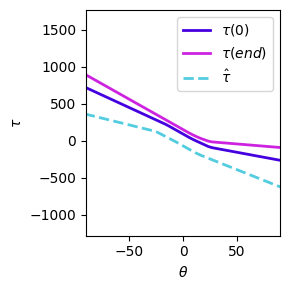

theta  -27.554185612062817
tau  375.94432201891516
desired tau  132.19506820342616
loss  -243.749253815489
MSE loss  59413.69873560768
delta theta -5242.83315863943
input_update  -36.533370924495145
tau  449.5736415808602
buckle pattern  [1. 1. 1. 1.]


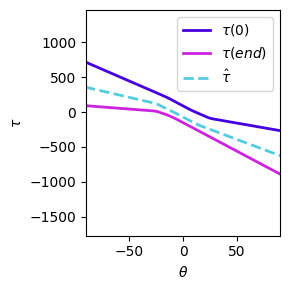

theta  -41.66034425278478
tau  34.49241310334174
desired tau  182.9772393100252
loss  148.48482620668346
MSE loss  22047.743613628994
delta theta 652.6723377652938
input_update  -20.2165624803628
tau  -10.373875102113443
buckle pattern  [1. 1. 1. 1.]


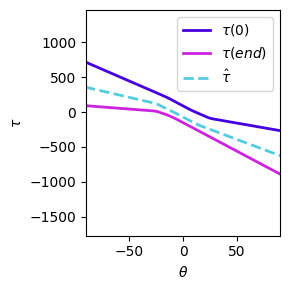

theta  -56.03201149958935
tau  51.73841379950723
desired tau  234.71524139852164
loss  182.97682759901443
MSE loss  33480.519438199444
delta theta 1133.2779642504663
input_update  8.11538662589886
tau  -216.54617033237068
buckle pattern  [1. 1. 1. 1.]


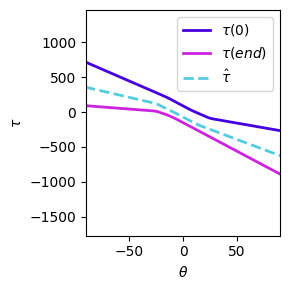

theta  -65.07350593666114
tau  62.58820712399337
desired tau  267.2646213719801
loss  204.67641424798677
MSE loss  41892.43454941348
delta theta 1499.198155833945
input_update  45.59534052174749
tau  -523.8817922783295
buckle pattern  [-1. -1. -1. -1.]


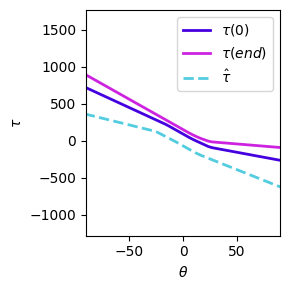

theta  79.232958728845
tau  -79.57955047461401
desired tau  -561.0511606273011
loss  -481.4716101526871
MSE loss  231814.9113830211
delta theta 4379.554743497242
input_update  155.08420910917854
tau  -170.60105093101427
buckle pattern  [-1. -1. -1. -1.]


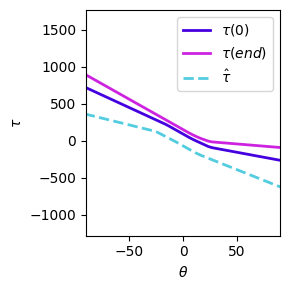

theta  66.36705467268933
tau  -64.1404656072272
desired tau  -486.4289171015982
loss  -422.288451494371
MSE loss  178327.5362655137
delta theta 3161.48652192219
input_update  234.1213721572333
tau  -265.44564658868
buckle pattern  [-1. -1. -1. -1.]


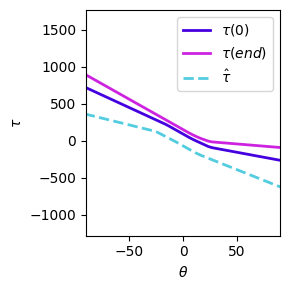

theta  -23.183867745816343
tau  340.10771551569394
desired tau  109.1973948682042
loss  -230.91032064748975
MSE loss  53319.576181526536
delta theta -4468.312012212165
input_update  122.41357185192916
tau  -131.396286222315
buckle pattern  [-1. -1. -1. -1.]


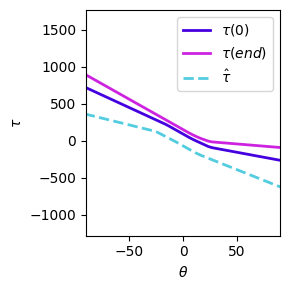

theta  31.791780482223103
tau  -22.650136578667723
desired tau  -285.892326796894
loss  -263.24219021822626
MSE loss  69296.45071088882
delta theta 832.0855277297788
input_update  143.21571004517364
tau  -156.35885205420837
buckle pattern  [-1. -1. -1. -1.]


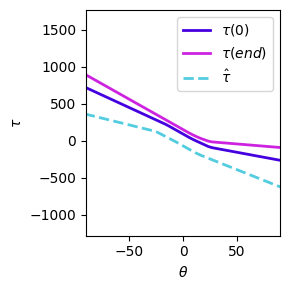

theta  -45.18393263509893
tau  520.5082476078112
desired tau  195.66215748635614
loss  -324.84609012145506
MSE loss  105524.98226719651
delta theta -9815.397157792364
input_update  -102.16921889963547
tau  987.7875949770107
buckle pattern  [1. 1. 1. 1.]


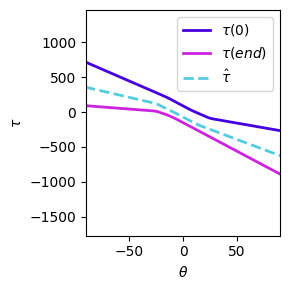

theta  16.884961842154866
tau  -288.45668710566997
desired tau  -199.43277868449826
loss  89.02390842117171
MSE loss  7925.256270581168
delta theta -1445.7621292084725
input_update  -138.3132721298473
tau  150.47592655581676
buckle pattern  [1. 1. 1. 1.]


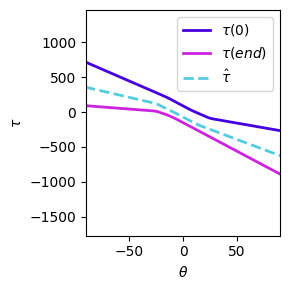

theta  3.427801771957334
tau  -178.10797453005011
desired tau  -98.10797453005014
loss  79.99999999999997
MSE loss  6399.999999999995
delta theta -767.5496811012403
input_update  -157.5020141573783
tau  173.50241698885398
buckle pattern  [1. 1. 1. 1.]


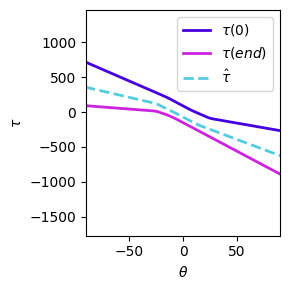

theta  -82.41365514087623
tau  83.39638616905148
desired tau  329.6891585071544
loss  246.2927723381029
MSE loss  60660.12970598859
delta theta 2338.3320182076145
input_update  -99.04371370218794
tau  103.35245644262554
buckle pattern  [1. 1. 1. 1.]


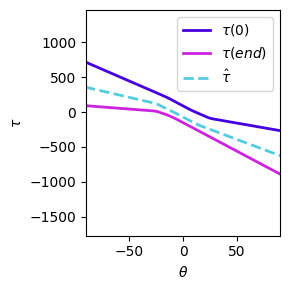

theta  -51.5380712643558
tau  46.34568551722696
desired tau  218.5370565516809
loss  172.19137103445394
MSE loss  29649.868258724982
delta theta 969.6667804921243
input_update  -74.80204418988484
tau  74.26245302786181
buckle pattern  [1. 1. 1. 1.]


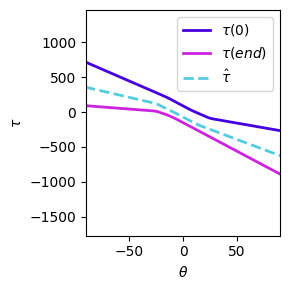

theta  -86.72329675723456
tau  88.56795610868149
desired tau  345.20386832604447
loss  256.635912217363
MSE loss  65861.99143963805
delta theta 2574.9015645882155
input_update  -10.42950507517945
tau  -68.1223159962977
buckle pattern  [1. 1. 1. 1.]


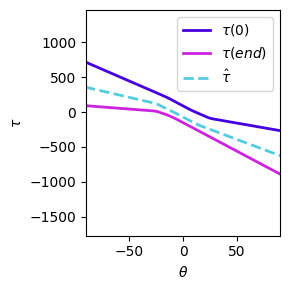

theta  85.19549598828343
tau  -848.6030671039241
desired tau  -595.633876732044
loss  252.96919037188013
MSE loss  63993.41127740453
delta theta -12642.17096478221
input_update  -326.4837791947347
tau  376.2805350336817
buckle pattern  [1. 1. 1. 1.]


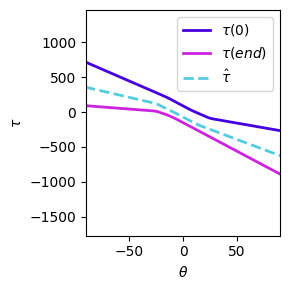

theta  4.0418884517495
tau  -183.14348530434592
desired tau  -103.1434853043459
loss  80.00000000000001
MSE loss  6400.000000000003
delta theta -791.8108940153724
input_update  -346.27905154511905
tau  400.0348618541429
buckle pattern  [1. 1. 1. 1.]


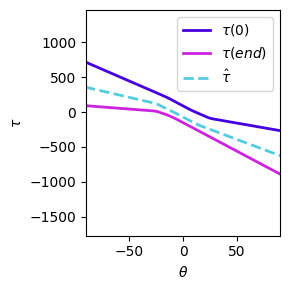

theta  -35.187977929655034
tau  26.725573515586042
desired tau  159.6767205467581
loss  132.95114703117207
MSE loss  17676.007496904334
delta theta 476.7367630917063
input_update  -334.3606324678264
tau  385.7327589613917
buckle pattern  [1. 1. 1. 1.]


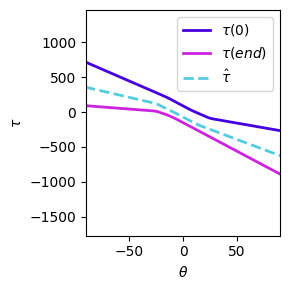

theta  -25.78774147092649
tau  15.445289765111792
desired tau  125.83586929533537
loss  110.39057953022358
MSE loss  12186.080049018616
delta theta 266.0146931315642
input_update  -327.7102651395373
tau  377.75231816744474
buckle pattern  [1. 1. 1. 1.]


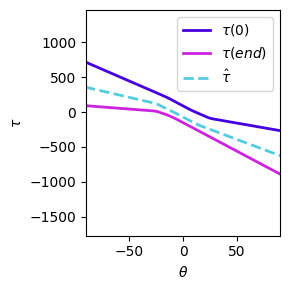

theta  83.62638842237956
tau  -835.7363850635124
desired tau  -586.5330528498015
loss  249.20333221371095
MSE loss  62102.30078641719
delta theta -12260.864054294154
input_update  -634.2318664968911
tau  745.5782397962694
buckle pattern  [1. 1. 1. 1.]


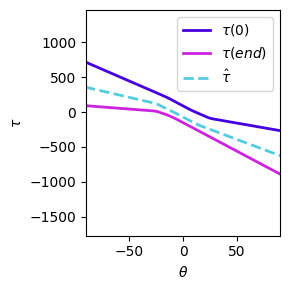

theta  50.722952341054906
tau  -565.9282091966502
desired tau  -395.69312357811845
loss  170.23508561853174
MSE loss  28979.984375548833
delta theta -5609.409854479954
input_update  -774.46711285889
tau  913.860535430668
buckle pattern  [1. 1. 1. 1.]


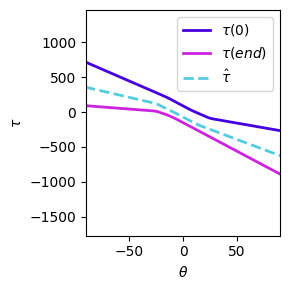

theta  -3.900462753667398
tau  -118.01620541992735
desired tau  -38.016205419927346
loss  80.0
MSE loss  6400.0
delta theta -478.0260815868679
input_update  -786.4177648985617
tau  928.201317878274
buckle pattern  [1. 1. 1. 1.]


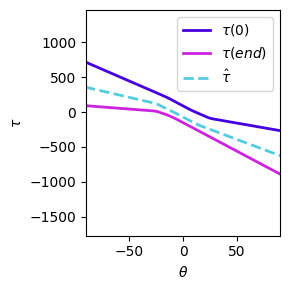

theta  18.919131118805097
tau  -305.1368751742018
desired tau  -211.2309604890696
loss  93.90591468513222
MSE loss  8818.32081285133
delta theta -1619.3816771331124
input_update  -826.9023068268896
tau  976.7827681922676
buckle pattern  [1. 1. 1. 1.]


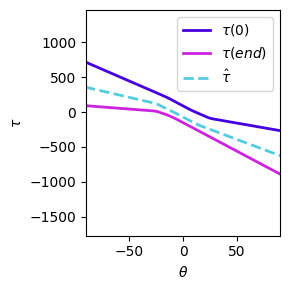

theta  -77.8962190611277
tau  77.97546287335324
desired tau  313.4263886200597
loss  235.45092574670645
MSE loss  55437.13843498107
delta theta 2102.3290579497943
input_update  -774.3440803781447
tau  913.7128964537736
buckle pattern  [1. 1. 1. 1.]


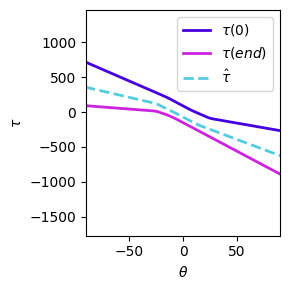

theta  -58.526941983902184
tau  54.732330380682626
desired tau  243.6969911420479
loss  188.96466076136528
MSE loss  35707.643016657865
delta theta 1229.3466106487756
input_update  -743.6104151119252
tau  876.8324981343103
buckle pattern  [1. 1. 1. 1.]


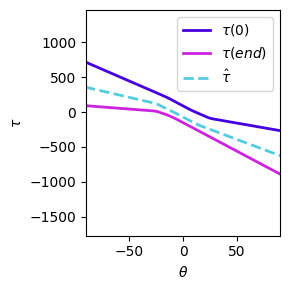

theta  -17.8841256503962
tau  -22.502546617939757
desired tau  68.91935494301113
loss  91.42190156095089
MSE loss  8357.964085020194
delta theta -7.169332281292318
input_update  -743.7896484189575
tau  877.047578102749
buckle pattern  [1. 1. 1. 1.]


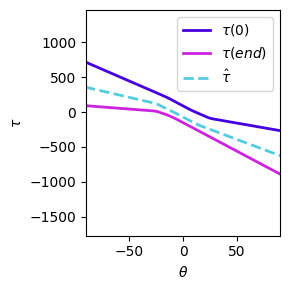

theta  -53.204128167505516
tau  48.34495380100662
desired tau  224.53486140301985
loss  176.18990760201322
MSE loss  31042.883540805957
delta theta 1028.9083800916333
input_update  -718.0669389166667
tau  846.1803267
buckle pattern  [1. 1. 1. 1.]


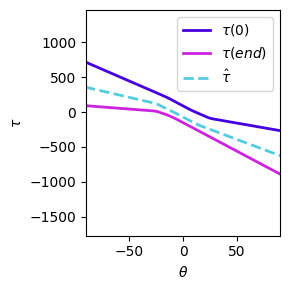

theta  66.8393430099554
tau  -698.0826126816344
desired tau  -489.1681894577414
loss  208.91442322389298
MSE loss  43645.236230971874
delta theta -8546.689278655618
input_update  -931.7341708830571
tau  1102.5810050596685
buckle pattern  [1. 1. 1. 1.]


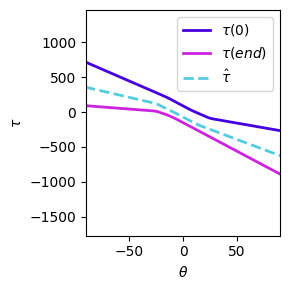

theta  -31.94109738905742
tau  22.829316866868904
desired tau  147.98795060060672
loss  125.15863373373782
MSE loss  15664.683598095933
delta theta 397.953545355839
input_update  -921.7853322491611
tau  1090.6423986989935
buckle pattern  [1. 1. 1. 1.]


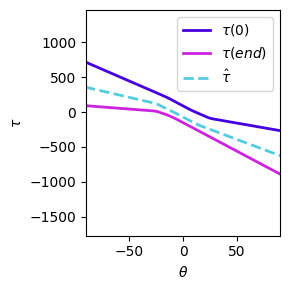

theta  72.14763579309383
tau  -741.6106135033694
desired tau  -519.9562875999442
loss  221.65432590342527
MSE loss  49130.64019170187
delta theta -9648.942651976886
input_update  -1163.0088985485831
tau  1380.1106782583
buckle pattern  [1. 1. 1. 1.]


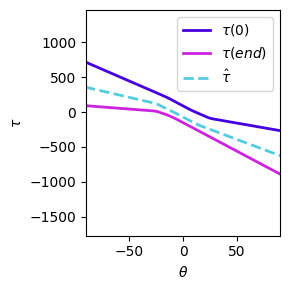

theta  76.71317462301383
tau  -779.0480319087135
desired tau  -546.4364128134803
loss  232.6116190952332
MSE loss  54108.165338105864
delta theta -10650.394663410845
input_update  -1429.2687651338542
tau  1699.622518160625
buckle pattern  [1. 1. 1. 1.]


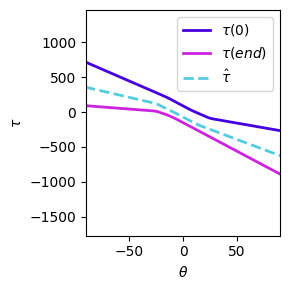

theta  -84.06006478456847
tau  85.37207774148217
desired tau  335.6162332244465
loss  250.24415548296432
MSE loss  62622.13735338202
delta theta 2427.391963359197
input_update  -1368.5839660498743
tau  1626.8007592598492
buckle pattern  [1. 1. 1. 1.]


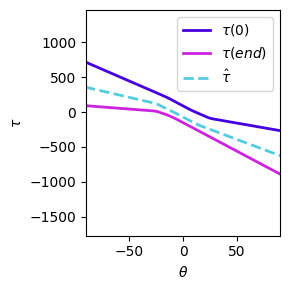

theta  75.25634236048796
tau  -767.1020073560012
desired tau  -537.9867856908302
loss  229.11522166517102
MSE loss  52493.784798680455
delta theta -10325.470402045816
input_update  -1626.7207261010199
tau  1936.564871321224
buckle pattern  [1. 1. 1. 1.]


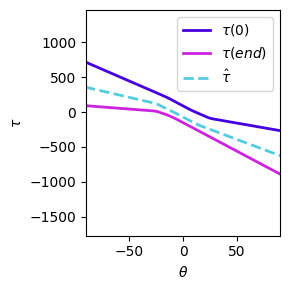

theta  -65.3994713647955
tau  62.97936563775461
desired tau  268.43809691326385
loss  205.45873127550925
MSE loss  42213.29025734193
delta theta 1513.3072021935695
input_update  -1588.8880460461805
tau  1891.1656552554168
buckle pattern  [1. 1. 1. 1.]


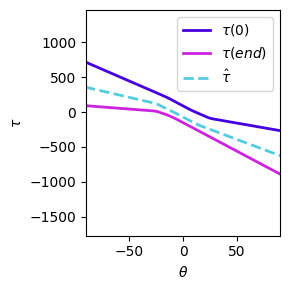

theta  59.44121799622272
tau  -637.4179875690263
desired tau  -446.2590643780918
loss  191.1589231909345
MSE loss  36541.733915517594
delta theta -7121.903944872048
input_update  -1766.9356446679817
tau  2104.8227736015783
buckle pattern  [1. 1. 1. 1.]


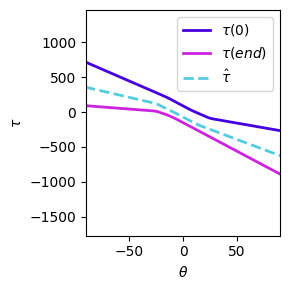

theta  12.902088250322407
tau  -255.79712365264373
desired tau  -173.18524422735356
loss  82.61187942529017
MSE loss  6824.722622178681
delta theta -1179.137822795044
input_update  -1796.4140902378579
tau  2140.1969082854293
buckle pattern  [1. 1. 1. 1.]


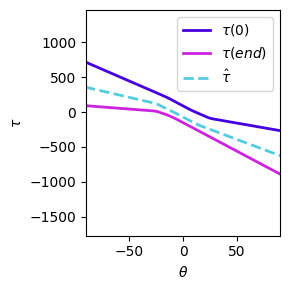

theta  -60.950861040919676
tau  57.641033249103614
desired tau  252.42309974731083
loss  194.7820664982072
MSE loss  37940.053429312014
delta theta 1326.2608828592784
input_update  -1763.257568166376
tau  2100.409081799651
buckle pattern  [1. 1. 1. 1.]


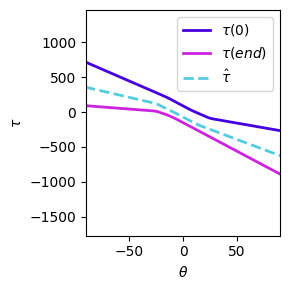

theta  59.772041182317906
tau  -640.1307376950069
desired tau  -448.17783885744393
loss  191.952898837563
MSE loss  36845.915372143696
delta theta -7182.8451981325
input_update  -1942.8286981196884
tau  2315.8944377436264
buckle pattern  [1. 1. 1. 1.]


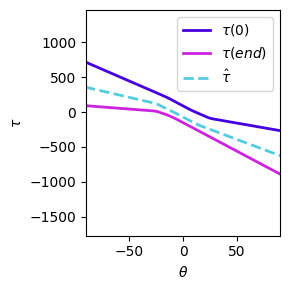

theta  -69.68290983019259
tau  68.1194917962311
desired tau  283.8584753886933
loss  215.7389835924622
MSE loss  46543.30904150868
delta theta 1704.6393593456366
input_update  -1900.2127141360475
tau  2264.755256963257
buckle pattern  [1. 1. 1. 1.]


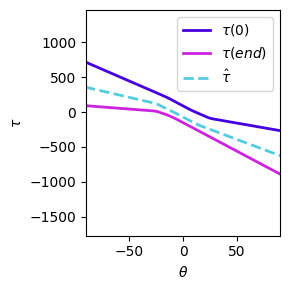

theta  20.681430410021918
tau  -319.58772936217974
desired tau  -221.45229637812713
loss  98.13543298405261
MSE loss  9630.563206967481
delta theta -1777.7265183399631
input_update  -1944.6558770945464
tau  2318.087052513456
buckle pattern  [1. 1. 1. 1.]


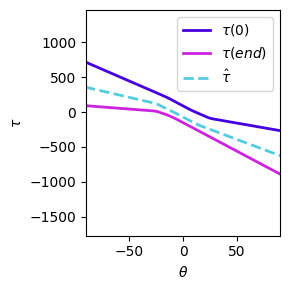

theta  -13.626958827688682
tau  -46.69937585448583
desired tau  36.564887090433984
loss  83.2642629449198
MSE loss  6932.937483760746
delta theta -134.59983876992916
input_update  -1948.0208730637946
tau  2322.1250476765535
buckle pattern  [1. 1. 1. 1.]


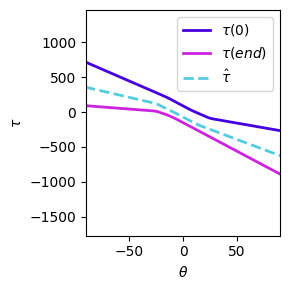

theta  51.84728296151039
tau  -575.1477202843852
desired tau  -402.2142411767602
loss  172.93347910762498
MSE loss  29905.988196267364
delta theta -5794.345458101228
input_update  -2092.8795095163255
tau  2495.9554114195907
buckle pattern  [1. 1. 1. 1.]


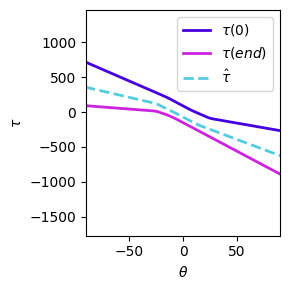

theta  78.66677700855112
tau  -795.0675714701192
desired tau  -557.7673066495965
loss  237.30026482052267
MSE loss  56311.41568389019
delta theta -11094.012718466383
input_update  -2370.229827477985
tau  2828.775792973582
buckle pattern  [1. 1. 1. 1.]


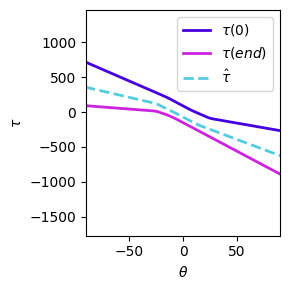

theta  56.067275388824584
tau  -609.7516581883616
desired tau  -426.6901972551826
loss  183.06146093317898
MSE loss  33511.498478989815
delta theta -6515.201803276826
input_update  -2533.109872559906
tau  3024.231847071887
buckle pattern  [1. 1. 1. 1.]


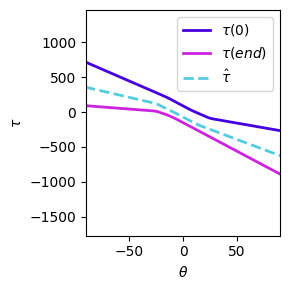

theta  -22.139862929208846
tau  -0.37271276811400256
desired tau  101.26295826198724
loss  101.63567103010124
MSE loss  10329.809625738959
delta theta 137.28190335234373
input_update  -2529.6778249760973
tau  3020.113389971317
buckle pattern  [1. 1. 1. 1.]


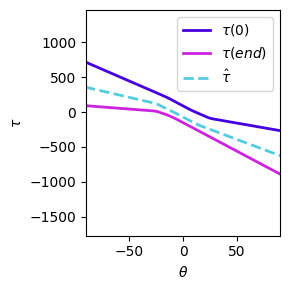

theta  8.708253003343728
tau  -221.40767462741854
desired tau  -141.40767462741857
loss  79.99999999999997
MSE loss  6399.999999999995
delta theta -976.1686852631786
input_update  -2554.082042107677
tau  3049.3984505292124
buckle pattern  [1. 1. 1. 1.]


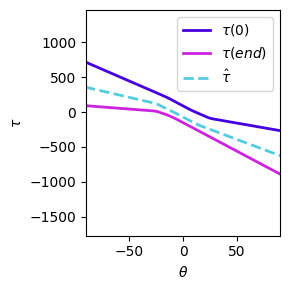

theta  4.3471303437295035
tau  -185.64646881858192
desired tau  -105.64646881858194
loss  79.99999999999999
MSE loss  6399.999999999998
delta theta -803.870329230846
input_update  -2574.178800338448
tau  3073.5145604061377
buckle pattern  [1. 1. 1. 1.]


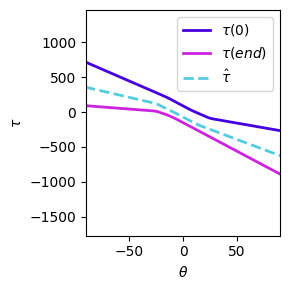

theta  -37.80027143435195
tau  29.86032572122234
desired tau  169.080977163667
loss  139.22065144244465
MSE loss  19382.389788058666
delta theta 544.7179165113256
input_update  -2560.560852425665
tau  3057.173022910798
buckle pattern  [1. 1. 1. 1.]


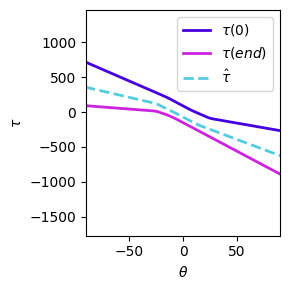

theta  82.88652530487099
tau  -829.669507499942
desired tau  -582.2418467682517
loss  247.42766073169037
MSE loss  61220.44729515647
delta theta -12083.095584543893
input_update  -2862.6382420392624
tau  3419.665890447115
buckle pattern  [1. 1. 1. 1.]


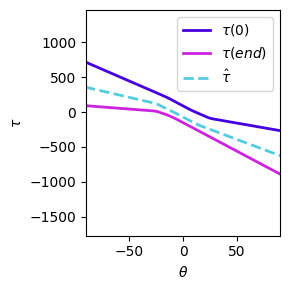

theta  -53.704237895003686
tau  48.94508547400442
desired tau  226.33525642201326
loss  177.39017094800883
MSE loss  31467.272748963795
delta theta 1047.0165434176845
input_update  -2836.4628284538203
tau  3388.255394144584
buckle pattern  [1. 1. 1. 1.]


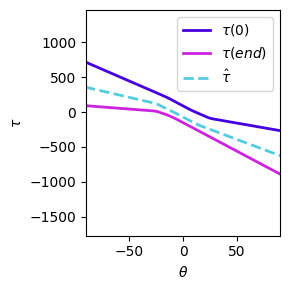

In [42]:
theta_full, tau_full_init = measure_full_response(Variabs, State.buckle)
theta_full, tau_full_desired  = measure_full_response(Variabs, desired_buckle)

for i in range(iterations):
    
    ## Measure
    Supervisor.set_theta(i)
    State.calc_tau(Supervisor.theta, Variabs)
    
    ## Loss
    Supervisor.calc_loss(State.tau)
    
    ## Update
    Supervisor.calc_input_update(State, Supervisor, Variabs)
    State.calc_tau(Supervisor.input_update, Variabs)
    State.evolve_material(Supervisor, Variabs)
    
    theta_full, tau_full_final = measure_full_response(Variabs, State.buckle)
    plot_func.plot_response(theta_full, tau_full_init, tau_full_final, tau_full_desired, theta_range=[-90, 90], just_init=False)

Supervisor.loss_MSE_norm_in_t = Supervisor.loss_MSE_in_t / (Variabs.k_bar * Variabs.theta_bar)

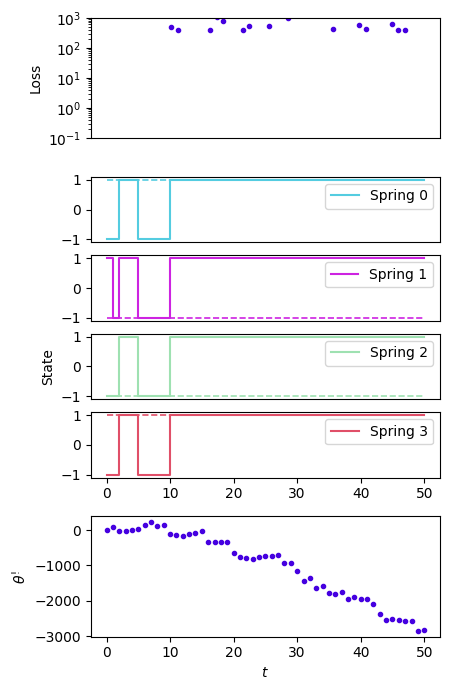

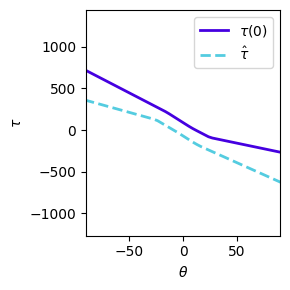

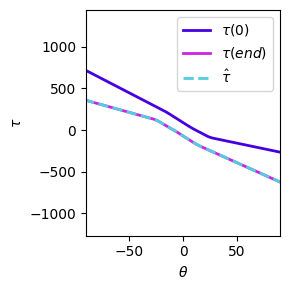

In [43]:
importlib.reload(plot_func)

plot_func.importants(State.buckle_in_t, Supervisor.desired_buckle, 
                     Supervisor.loss_MSE_norm_in_t, Supervisor.input_update_in_t)

plot_func.plot_response(theta_full, tau_full_init, tau_full_desired, tau_full_desired, theta_range=[-90, 90], just_init=True)
plot_func.plot_response(theta_full, tau_full_init, tau_full_desired, tau_full_desired, theta_range=[-90, 90], just_init=False)

In [ ]:
plot_response(theta_full, tau_full_init, tau_full_final, tau_full_desired, theta_range=[-90, 90], just_init=True)
